<a href="https://colab.research.google.com/github/abhigyan2003/keystroke/blob/main/SEQLEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch

# Load both user files
df1 = pd.read_csv("/content/User1.csv")
df2 = pd.read_csv("/content/User9.csv")

df = pd.concat([df1, df2], ignore_index=True)

# Clean
df = df[df['EventType'].isin(['press', 'release'])].dropna(subset=['Key', 'Username'])
df = df.sort_values('Timestamp').reset_index(drop=True)

# Encode key values and usernames
key_encoder = LabelEncoder()
user_encoder = LabelEncoder()

df['KeyEncoded'] = key_encoder.fit_transform(df['Key'])
df['UserEncoded'] = user_encoder.fit_transform(df['Username'])

print(user_encoder.classes_)  # should print ['User1' 'User2']


['User1' 'User9']


In [3]:
columns_to_show = ['Timestamp', 'Key', 'EventType', 'Username']

print("User1 Samples:")
print(df[df['Username'] == 'User1'][columns_to_show])

print("\nUser9 Samples:")
print(df[df['Username'] == 'User9'][columns_to_show])


User1 Samples:
                      Timestamp          Key EventType Username
0       2017-03-20 01:25:20,894    Key.alt_l   release    User1
1       2017-03-20 01:25:20,910   Key.ctrl_l   release    User1
2       2017-03-20 01:25:20,910    Key.shift   release    User1
3       2017-03-20 01:25:20,910      Key.cmd   release    User1
4       2017-03-20 01:25:20,910    Key.alt_r   release    User1
...                         ...          ...       ...      ...
357100  2017-03-24 20:02:57,163  Key.shift_r   release    User1
357101  2017-03-24 20:02:57,163    Key.cmd_r   release    User1
357102  2017-03-24 20:02:57,927   Key.ctrl_l   release    User1
357103  2017-03-24 20:02:57,927   Key.ctrl_l   release    User1
357104  2017-03-24 20:02:57,943    Key.shift   release    User1

[194326 rows x 4 columns]

User9 Samples:
                      Timestamp          Key EventType Username
2661    2017-03-20 11:07:52,842   Key.ctrl_l   release    User9
2662    2017-03-20 11:07:52,852   Key.ctrl_r  

In [4]:
print("\n🔍 Unique Event Types present in the data:")
print(df['EventType'].unique())



🔍 Unique Event Types present in the data:
['release' 'press']


In [5]:
print("🔑 Unique key values in the dataset:")
print(df['Key'].unique())
print("\n🔢 Total number of unique keys:")
print(df['Key'].nunique())
print("\n📊 Frequency of each key (top 20):")
print(df['Key'].value_counts().head(10))  # show top 20 most used keys



🔑 Unique key values in the dataset:
['Key.alt_l' 'Key.ctrl_l' 'Key.shift' 'Key.cmd' 'Key.alt_r' 'Key.ctrl_r'
 'Key.shift_r' 'Key.cmd_r' "u'LEFT'" "u'RIGHT'" "u'CENTER'" "u'None'"
 'Key.backspace' 'Key.space' 'Key.enter' "u'DIGIT'" 'Key.tab' 'Key.up'
 'Key.down' 'Key.delete' 'Key.caps_lock' 'Key.right' 'Key.num_lock'
 'Key.left' '<241>' '<234>' 'Key.end' 'Key.home' 'Key.f3' 'Key.esc'
 '<175>' '<174>' '<135>' '<47>' 'Key.f11' 'Key.f12' 'Key.f5' 'Key.f7']

🔢 Total number of unique keys:
38

📊 Frequency of each key (top 20):
Key
u'LEFT'          82575
u'RIGHT'         69652
u'CENTER'        65371
Key.space        35395
u'None'          22081
Key.backspace    20993
Key.shift        20594
Key.ctrl_l       16396
Key.enter         5329
u'DIGIT'          3927
Name: count, dtype: int64


In [28]:
SEQ_LEN = 80

X, y = [], []

for i in range(len(df) - SEQ_LEN):
    keys = df['KeyEncoded'].iloc[i:i+SEQ_LEN].tolist()
    users = df['UserEncoded'].iloc[i:i+SEQ_LEN]
    if len(set(users)) == 1:  # one user per sequence
        X.append(keys)
        y.append(users.iloc[0])

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

print(f"Dataset shape: {X.shape}, Labels: {y.unique()}")

Dataset shape: torch.Size([265008, 80]), Labels: tensor([0, 1])


In [29]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        H = self.num_heads

        Q = self.q_linear(x).view(B, T, H, self.d_k).transpose(1, 2)  # (B, H, T, d_k)
        K = self.k_linear(x).view(B, T, H, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, T, H, self.d_k).transpose(1, 2)

        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)  # (B, H, T, T)
        weights = torch.softmax(scores, dim=-1)
        out = weights @ V  # (B, H, T, d_k)

        out = out.transpose(1, 2).contiguous().view(B, T, D)
        return self.out_proj(out)


In [31]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim=128, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out = self.attn(x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


In [32]:
class KeystrokeClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, d_model=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_enc(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)  # Global mean pooling
        return self.classifier(x)


In [33]:
from torch.utils.data import TensorDataset, DataLoader

# Create dataset from tensors
dataset = TensorDataset(X, y)

# Sequential (non-random) split
train_size = int(0.8 * len(dataset))
train_ds = TensorDataset(X[:train_size], y[:train_size])
val_ds = TensorDataset(X[train_size:], y[train_size:])

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# Model, loss, and optimizer
model = KeystrokeClassifier(vocab_size=len(key_encoder.classes_), num_classes=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert y tensor to numpy for sklearn
y_np = y.numpy()

# Compute weights: make sure classes are in [0, 1, 2, ..., N]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_np), y=y_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [35]:
loss_fn = nn.CrossEntropyLoss(weight=class_weights)


In [36]:
# After class_weights is calculated
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

model = KeystrokeClassifier(vocab_size=len(key_encoder.classes_), num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [37]:
print("Class Weights:", class_weights)


Class Weights: tensor([0.9055, 1.1165])


In [38]:
import time
from tqdm import tqdm  # install with `pip install tqdm` if needed

def train(model, train_dl, val_dl, epochs=10):
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_loss = 0

        print(f"\n--- Epoch {epoch+1} ---")

        progress_bar = tqdm(train_dl, desc=f"Training", leave=False)
        for i, (xb, yb) in enumerate(progress_bar, 1):
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            progress_bar.set_postfix(Step=i, Loss=loss.item())

        # === Validation ===
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                preds = model(xb)
                correct += (preds.argmax(dim=1) == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:2d} | Total Loss: {total_loss:.4f} | Val Acc: {acc:.2%} | Time: {epoch_time:.2f}s")


In [39]:
train(model, train_dl, val_dl, epochs=10)




--- Epoch 1 ---


Epoch  1 | Total Loss: 2682.3814 | Val Acc: 82.93% | Time: 357.95s

--- Epoch 2 ---


Epoch  2 | Total Loss: 2247.0322 | Val Acc: 84.35% | Time: 359.90s

--- Epoch 3 ---


Epoch  3 | Total Loss: 2072.5274 | Val Acc: 83.05% | Time: 390.46s

--- Epoch 4 ---


Epoch  4 | Total Loss: 1908.6090 | Val Acc: 83.16% | Time: 362.36s

--- Epoch 5 ---


Epoch  5 | Total Loss: 1763.8878 | Val Acc: 83.62% | Time: 369.95s

--- Epoch 6 ---


Epoch  6 | Total Loss: 1645.3716 | Val Acc: 85.71% | Time: 370.34s

--- Epoch 7 ---


Epoch  7 | Total Loss: 1506.0945 | Val Acc: 85.15% | Time: 368.64s

--- Epoch 8 ---


Epoch  8 | Total Loss: 1383.8198 | Val Acc: 85.28% | Time: 374.62s

--- Epoch 9 ---


Epoch  9 | Total Loss: 1252.3985 | Val Acc: 87.35% | Time: 380.10s

--- Epoch 10 ---


Epoch 10 | Total Loss: 548.0371 | Val Acc: 94.22% | Time: 379.32s


In [40]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_true.extend(yb.tolist())
        y_pred.extend(preds.tolist())

print(classification_report(y_true, y_pred, target_names=user_encoder.classes_))


              precision    recall  f1-score   support

       User1       0.92      0.89      0.91     16440
       User9       0.95      0.96      0.96     36562

    accuracy                           0.94     53002
   macro avg       0.94      0.93      0.93     53002
weighted avg       0.94      0.94      0.94     53002



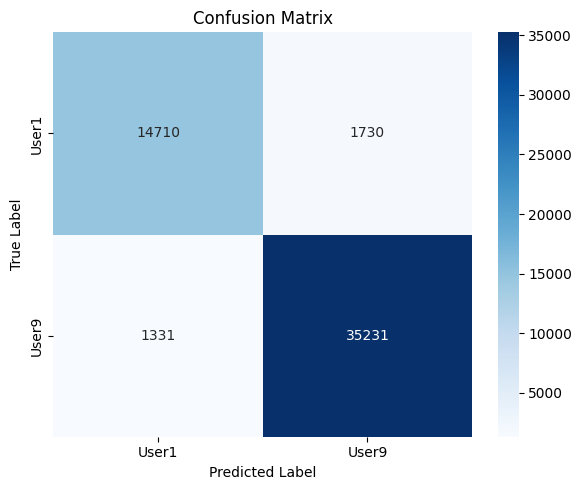

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Run prediction loop again (required to define y_true and y_pred)
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_true.extend(yb.tolist())
        y_pred.extend(preds.tolist())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = user_encoder.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [42]:
import torch

# Count the number of samples for each user label
unique_classes, counts = torch.unique(y, return_counts=True)

# Decode class labels (assuming you used user_encoder to encode labels)
for label, count in zip(unique_classes, counts):
    print(f"{user_encoder.inverse_transform([label.item()])[0]}: {count.item()} samples")


User1: 146335 samples
User9: 118673 samples


In [43]:
!pip install torchinfo

In [44]:

from torchinfo import summary
vocab_size = len(key_encoder.classes_)     # Number of unique keys
num_classes = len(user_encoder.classes_)   # Number of users (classes)
sequence_length = 20                       # As used during sequence creation

model = KeystrokeClassifier(vocab_size, num_classes)

summary(model, input_size=(1, sequence_length), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
KeystrokeClassifier                      [1, 2]                    --
├─Embedding: 1-1                         [1, 20, 64]               2,432
├─PositionalEncoding: 1-2                [1, 20, 64]               --
├─ModuleList: 1-3                        --                        --
│    └─TransformerEncoderBlock: 2-1      [1, 20, 64]               --
│    │    └─MultiHeadAttention: 3-1      [1, 20, 64]               16,640
│    │    └─Dropout: 3-2                 [1, 20, 64]               --
│    │    └─LayerNorm: 3-3               [1, 20, 64]               128
│    │    └─Sequential: 3-4              [1, 20, 64]               16,576
│    │    └─Dropout: 3-5                 [1, 20, 64]               --
│    │    └─LayerNorm: 3-6               [1, 20, 64]               128
│    └─TransformerEncoderBlock: 2-2      [1, 20, 64]               --
│    │    └─MultiHeadAttention: 3-7      [1, 20, 64]               16,64

In [45]:
from collections import Counter

def check_distribution(dl, name):
    all_labels = []
    for _, yb in dl:
        all_labels.extend(yb.tolist())
    dist = Counter(all_labels)
    print(f"{name} class distribution:", {user_encoder.inverse_transform([k])[0]: v for k, v in dist.items()})

print(f"Training Set Size: {len(train_ds)} | Validation Set Size: {len(val_ds)}")
check_distribution(train_dl, "Train")
check_distribution(val_dl, "Validation")


Training Set Size: 212006 | Validation Set Size: 53002
Train class distribution: {'User1': 129895, 'User9': 82111}
Validation class distribution: {'User9': 36562, 'User1': 16440}


In [46]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Filter original DataFrame for only User1
user_name = 'User1'
user_label = user_encoder.transform([user_name])[0]
user1_df = df[df['UserEncoded'] == user_label]

SEQ_LEN = 20
num_samples = 5

print(f"\n--- Predictions for User {user_name} ---")
for i in range(num_samples):
    start_idx = torch.randint(0, len(user1_df) - SEQ_LEN, (1,)).item()
    segment = user1_df.iloc[start_idx : start_idx + SEQ_LEN]
    key_seq = torch.tensor([segment['KeyEncoded'].tolist()], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(key_seq)
        pred_class = torch.argmax(output, dim=1).item()

    pred_user = user_encoder.inverse_transform([pred_class])[0]
    print(f"True: {user_name} | Predicted: {pred_user}")



--- Predictions for User User1 ---
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User9


AUC Score: 0.4201


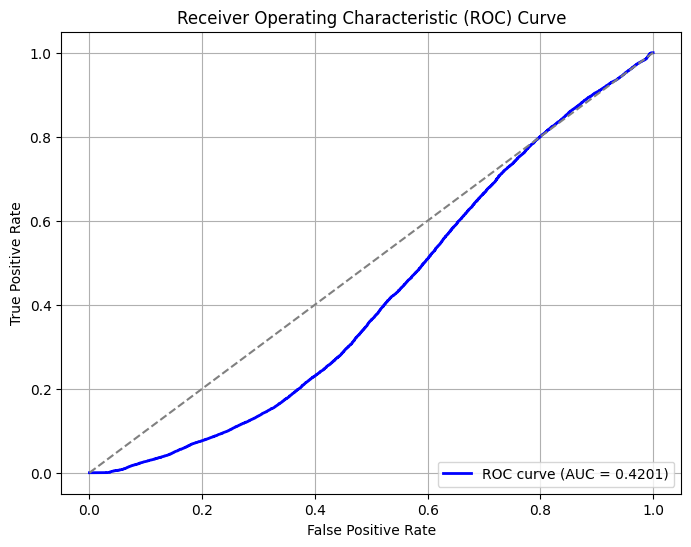

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Put model in eval mode and move to device
model.eval()
model.to(device)

y_true = []
y_probs = []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class 'User9'

        y_true.extend(yb.cpu().tolist())
        y_probs.extend(probs.cpu().tolist())

# Calculate AUC
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
